Применим знания на практике: с помощью pandahouse попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python. 

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

In [1]:
#импортируем нужные либы
import pandahouse as ph
import pandas as pd

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
#объявляем параметры подключения
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [12]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT
id,
toFloat32(replaceRegexpAll(price, '[$,]', '')) AS price,
room_type,
review_scores_rating AS rew_sc_r
FROM default.ldn_listings
ORDER BY
id
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)

In [13]:
df.dtypes

id            uint32
price        float32
room_type     object
rew_sc_r      object
dtype: object

In [14]:
df.query("room_type =='Private room'").quantile(q=0.75)

id       453442.5
price        70.0
Name: 0.75, dtype: float64

In [19]:
b = df.groupby(['room_type'])['price'].quantile(q=0.75).reset_index()

In [20]:
b

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


In [21]:
df[['rew_sc_r']] = df[['rew_sc_r']].apply(pd.to_numeric)

In [22]:
df.dtypes

id            uint32
price        float32
room_type     object
rew_sc_r     float64
dtype: object

In [24]:
a = df.groupby('room_type', as_index = False) \
    .agg({'rew_sc_r':'mean', 'price':'mean'})

In [25]:
a

,room_type,rew_sc_r,price
0,Entire home/apt,93.663212,153.182846
1,Hotel room,92.500000,134.000000
2,Private room,94.720096,66.820328
3,Shared room,90.000000,61.250000


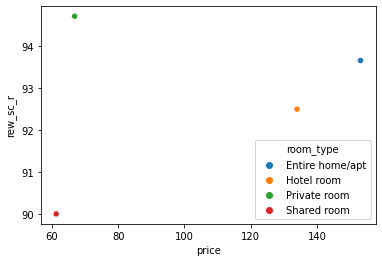

In [26]:
sns.scatterplot(data=a, x="price", y="rew_sc_r", hue="room_type")

In [28]:
query = """
SELECT
DISTINCT host_id,
host_verifications
FROM default.ldn_listings
WHERE
experiences_offered != 'none'

"""
df = ph.read_clickhouse(query, connection=connection)

In [29]:
df.host_verifications = df.host_verifications.str.strip('[]').str.split(',')
df = df.explode('host_verifications')
df.host_verifications.value_counts()

 'phone'                    1345
'email'                     1345
 'reviews'                  1309
 'government_id'            1196
 'jumio'                    1115
 'offline_government_id'     469
 'work_email'                279
 'facebook'                  270
 'selfie'                    252
 'identity_manual'           227
 'manual_offline'             70
 'google'                     34
 'kba'                        27
 'manual_online'              16
'phone'                       16
 'sent_id'                     6
Name: host_verifications, dtype: int64

In [30]:
query = """
SELECT
neighbourhood_cleansed,
experiences_offered,
COUNT(experiences_offered) AS experiences_count
FROM
ldn_listings
WHERE
experiences_offered != 'none' 
GROUP BY
neighbourhood_cleansed,
experiences_offered
ORDER BY
experiences_count DESC
LIMIT 100
"""
exp_count = ph.read_clickhouse(query, connection=connection)

In [31]:
exp_count = exp_count.pivot(index="neighbourhood_cleansed", columns="experiences_offered", values="experiences_count")

In [32]:
exp_count.query('neighbourhood_cleansed == "City of London"')

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
City of London,7.0,1.0,NaN,NaN


In [33]:
exp_count

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


In [34]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(10,15)}
        )

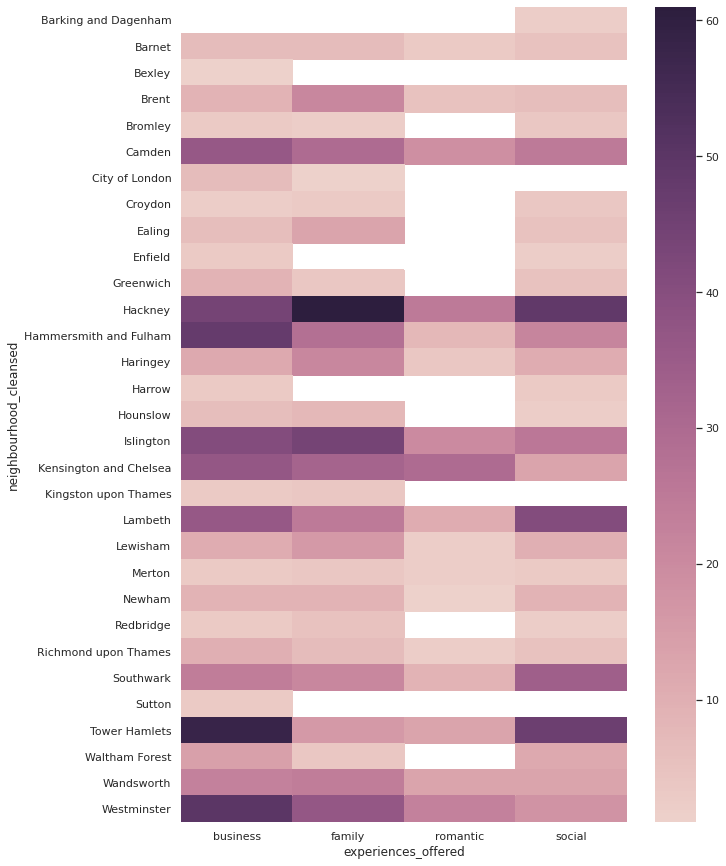

In [35]:
sns.heatmap(exp_count, cmap=sns.cubehelix_palette(as_cmap=True))

In [36]:
query = '''
SELECT
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr,
    room_type
FROM
    ldn_listings
WHERE
    experiences_offered != 'none'
'''

In [37]:
df = ph.read_clickhouse(query, connection=connection)

In [41]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(10,6)}
        )

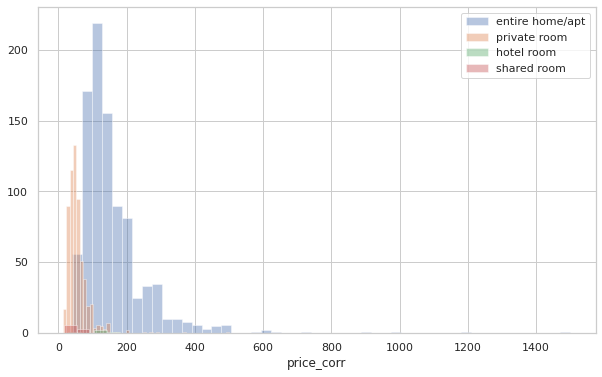

In [42]:
sns.distplot((df.query("room_type=='Entire home/apt'").price_corr), kde=False, label='entire home/apt')
sns.distplot((df.query("room_type=='Private room'").price_corr), kde=False, label='private room')
sns.distplot((df.query("room_type=='Hotel room'").price_corr), kde=False, label='hotel room')
sns.distplot((df.query("room_type=='Shared room'").price_corr), kde=False, label='shared room')
plt.legend()
plt.show()

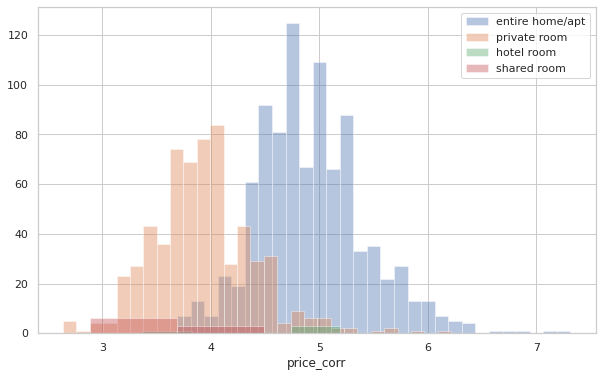

In [43]:
sns.distplot(np.log(df.query("room_type=='Entire home/apt'").price_corr), kde=False, label='entire home/apt')
sns.distplot(np.log(df.query("room_type=='Private room'").price_corr), kde=False, label='private room')
sns.distplot(np.log(df.query("room_type=='Hotel room'").price_corr), kde=False, label='hotel room')
sns.distplot(np.log(df.query("room_type=='Shared room'").price_corr), kde=False, label='shared room')
plt.legend()
plt.show()

In [44]:
query = '''
SELECT 
        room_type
    ,   toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr
    ,   first_review
FROM
        ldn_listings
where first_review > '2010-01-01'
LIMIT 1000
'''
df = ph.read_clickhouse(query, connection=connection)

In [45]:
df['year'] = df.first_review.apply(lambda x: x[:4])

In [46]:
df = df.groupby(['year', 'room_type'], as_index=False) \
    .agg({'price_corr': 'mean'})

In [47]:
df

,year,room_type,price_corr
0,2010,Entire home/apt,103.500000
1,2010,Hotel room,88.000000
2,2010,Private room,56.428570
3,2011,Entire home/apt,128.792450
4,2011,Private room,52.607143
5,2012,Entire home/apt,135.467255
6,2012,Private room,53.269840
7,2012,Shared room,22.000000
8,2013,Entire home/apt,137.887634
9,2013,Private room,57.036587


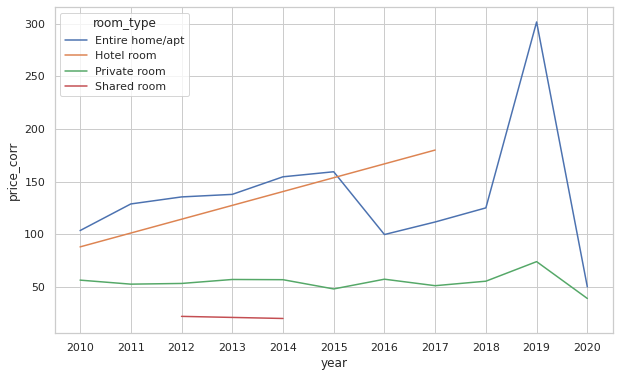

In [48]:
sns.lineplot(data=df, hue='room_type', x = 'year', y='price_corr')